In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 200.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 206.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 334.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 152.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 167.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 197.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1


# Dataset

In [8]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/zddtpgzv63-4.zip

--2024-10-19 15:37:33--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/zddtpgzv63-4.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.93.32, 52.218.98.168, 3.5.71.17, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.93.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2212309361 (2.1G) [application/octet-stream]
Saving to: ‘zddtpgzv63-4.zip’

zddtpgzv63-4.zip    100%[===================>]   2.06G  42.5MB/s    in 52s     

2024-10-19 15:38:25 (40.2 MB/s) - ‘zddtpgzv63-4.zip’ saved [2212309361/2212309361]



In [9]:
!unzip zddtpgzv63-4.zip

Archive:  zddtpgzv63-4.zip
   creating: High squamous intra-epithelial lesion/
  inflating: High squamous intra-epithelial lesion/HSIL_8 (9).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_10 (8).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_2 (7).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_10 (17).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_6 (3).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_8 (1).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_5 (22).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_4 (5).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_6 (21).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_7 (11).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_5 (4).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_5 (13).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_8 (10).jpg  
  inflating: High squamous in

# Data preprocessing

In [64]:
import tensorflow as tf
import os

DATASET_DIR = 'dataset' 

# Đường dẫn tới các thư mục lớp
class_names = ['High squamous intra-epithelial lesion', 'Low squamous intra-epithelial lesion', 'Negative for Intraepithelial malignancy', 'Squamous cell carcinoma']
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",    
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="validation",   
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)


Found 962 files belonging to 4 classes.
Using 770 files for training.
Found 962 files belonging to 4 classes.
Using 192 files for validation.


In [65]:
# Split data
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

In [66]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 1


# Configure the dataset for performance

In [67]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation

In [68]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

2024-10-19 15:50:58.200417: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


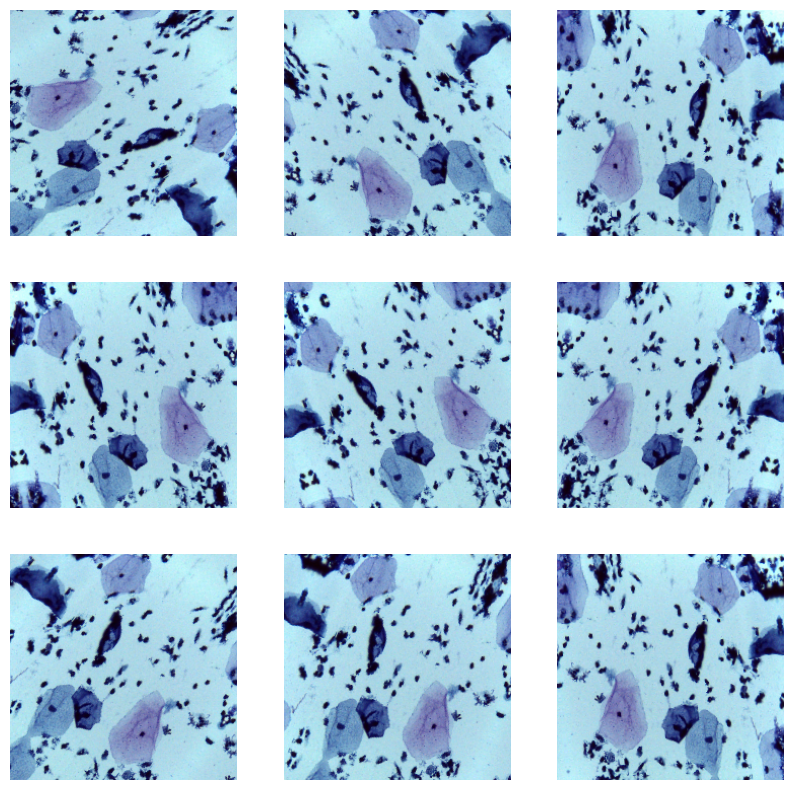

In [69]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Rescale pixel values

In [70]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [71]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # [-1, 1] or [0, 1]

# Create the base model from the pre-trained convnets

In [72]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input
# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [73]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1024)


# Feature extraction

## Freeze the convolutional base

In [74]:
base_model.trainable = False

In [75]:
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

## Add a classification head

In [76]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1024)


In [77]:
prediction_layer = tf.keras.layers.Dense(4, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 4)


In [78]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [79]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,964 (12.33 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [80]:
len(model.trainable_variables)

2

## Compile the model

In [81]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

## Train the model

In [82]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_dataset)

2024-10-19 15:51:03.146096: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.5872 - loss: 0.6909


In [83]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.59


In [84]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=3,             
    restore_best_weights=True 
)

In [85]:

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6599 - loss: 0.6376 - val_accuracy: 0.7363 - val_loss: 0.5796
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7290 - loss: 0.5699 - val_accuracy: 0.7930 - val_loss: 0.5104
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7807 - loss: 0.5149 - val_accuracy: 0.7793 - val_loss: 0.4992
Epoch 4/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.7900 - loss: 0.4805

2024-10-19 15:52:04.995439: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7914 - loss: 0.4800 - val_accuracy: 0.7891 - val_loss: 0.4714
Epoch 5/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.8203 - loss: 0.4592

2024-10-19 15:52:19.928771: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8200 - loss: 0.4588 - val_accuracy: 0.8184 - val_loss: 0.4251
Epoch 6/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.8206 - loss: 0.4411

2024-10-19 15:52:40.421015: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8211 - loss: 0.4408 - val_accuracy: 0.7891 - val_loss: 0.4465
Epoch 7/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.8268 - loss: 0.4224

2024-10-19 15:52:55.244682: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8269 - loss: 0.4230 - val_accuracy: 0.8223 - val_loss: 0.4174
Epoch 8/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.8253 - loss: 0.4203

2024-10-19 15:53:10.031556: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8263 - loss: 0.4190 - val_accuracy: 0.8379 - val_loss: 0.3897
Epoch 9/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.8348 - loss: 0.4129

2024-10-19 15:53:25.022345: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8358 - loss: 0.4116 - val_accuracy: 0.8379 - val_loss: 0.3906
Epoch 10/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.8396 - loss: 0.3934

2024-10-19 15:53:39.969035: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8402 - loss: 0.3928 - val_accuracy: 0.8652 - val_loss: 0.3534
Epoch 11/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - accuracy: 0.8423 - loss: 0.3964

2024-10-19 15:53:54.981286: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8432 - loss: 0.3944 - val_accuracy: 0.8535 - val_loss: 0.3672
Epoch 12/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.8489 - loss: 0.3761

2024-10-19 15:54:15.472414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8491 - loss: 0.3760 - val_accuracy: 0.8730 - val_loss: 0.3417
Epoch 13/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.8691 - loss: 0.3467

2024-10-19 15:54:30.402198: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8675 - loss: 0.3491 - val_accuracy: 0.8535 - val_loss: 0.3655
Epoch 14/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.8507 - loss: 0.3678

2024-10-19 15:54:45.336541: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8515 - loss: 0.3664 - val_accuracy: 0.8691 - val_loss: 0.3525
Epoch 15/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.8510 - loss: 0.3594

2024-10-19 15:55:00.110691: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8521 - loss: 0.3583 - val_accuracy: 0.8691 - val_loss: 0.3259


## Learning curves

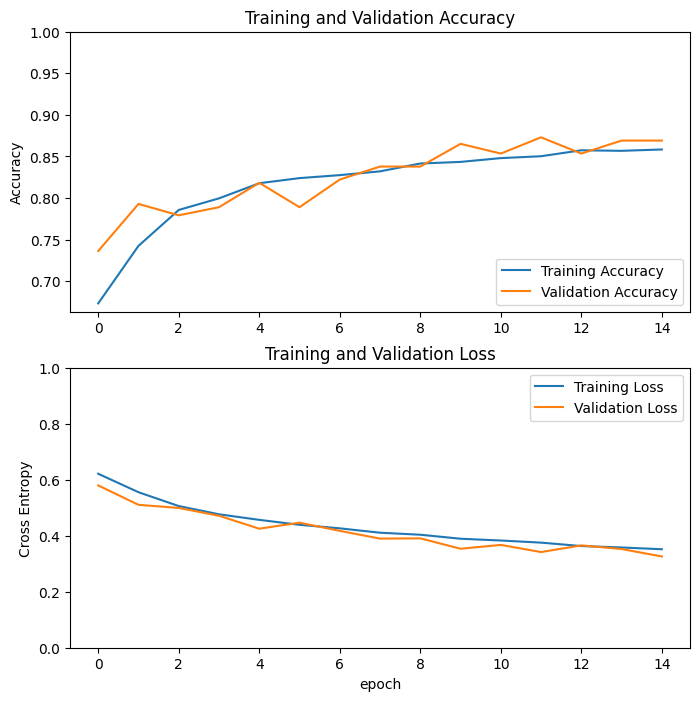

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

### Un-freeze the top layers of the model

In [88]:
base_model.trainable = True

In [89]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  86


In [90]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [91]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,964 (12.33 MB)

 Trainable params: 2,668,548 (10.18 MB)

 Non-trainable params: 564,416 (2.15 MB)

In [92]:
len(model.trainable_variables)   

37

In [96]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_filepath = 'mobileNet_v1_checkpoint.keras'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  
    monitor='val_loss',   
    mode='min',         
    save_weights_only=False,  
    verbose=1            
)

In [97]:
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=3,           
    restore_best_weights=True  
)

In [ ]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset,
                         callbacks=[checkpoint_callback, early_stopping])

Epoch 16/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8473 - loss: 0.4445

2024-10-19 15:56:29.929818: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 16: val_loss improved from inf to 0.30349, saving model to mobileNet_v1_checkpoint.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8477 - loss: 0.4429 - val_accuracy: 0.8848 - val_loss: 0.3035
Epoch 17/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8589 - loss: 0.3801

2024-10-19 15:56:51.883498: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 17: val_loss did not improve from 0.30349
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8595 - loss: 0.3783 - val_accuracy: 0.8574 - val_loss: 0.3121
Epoch 18/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8712 - loss: 0.3155

2024-10-19 15:57:13.385162: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 18: val_loss improved from 0.30349 to 0.28952, saving model to mobileNet_v1_checkpoint.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8719 - loss: 0.3139 - val_accuracy: 0.8594 - val_loss: 0.2895
Epoch 19/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8992 - loss: 0.2367

2024-10-19 15:57:35.699591: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 19: val_loss improved from 0.28952 to 0.27995, saving model to mobileNet_v1_checkpoint.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8986 - loss: 0.2380 - val_accuracy: 0.8652 - val_loss: 0.2800
Epoch 20/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8979 - loss: 0.2447

2024-10-19 15:57:59.507249: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 20: val_loss improved from 0.27995 to 0.24477, saving model to mobileNet_v1_checkpoint.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8980 - loss: 0.2443 - val_accuracy: 0.8906 - val_loss: 0.2448
Epoch 21/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9092 - loss: 0.2176

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
  plt.axis("off")